In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.cluster.hierarchy as shc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [2]:
# Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NPB 198 Final Project/Data 2

Mounted at /content/drive
/content/drive/My Drive/NPB 198 Final Project/Data 2


# Stage 1: Data Loading/Organization

In [3]:
# Extract output data from IS/ISA/CAN/HAS data csv's into dataframes
is_output = pd.read_csv("sem rep IS data.csv", delimiter=",", header=0, index_col=0)
isa_output = pd.read_csv("sem rep ISA data.csv", delimiter=",", header=0, index_col=0)
can_output = pd.read_csv("sem rep CAN data.csv", delimiter=",", header=0, index_col=0)
has_output = pd.read_csv("sem rep HAS data.csv", delimiter=",", header=0, index_col=0)

In [4]:
# Extracts lists of animals and attributes from dataframes
animals_list = is_output.index.values
attributes_list = is_output.columns.values

# Create list of relation names
relations_list = ["IS", "ISA", "CAN", "HAS"]

In [5]:
# Turn dataframes into tensors for outputs
is_output_numpy = is_output.to_numpy()
isa_output_numpy = isa_output.to_numpy()
can_output_numpy = can_output.to_numpy()
has_output_numpy = has_output.to_numpy()

In [6]:
# Make lists of animal and relation inputs

animal_inputs = [[1,0,0,0,0,0,0,0], # grizzly bear
                [0,1,0,0,0,0,0,0], # black bear
                [0,0,1,0,0,0,0,0], # bald eagle
                [0,0,0,1,0,0,0,0], # golden eagle
                [0,0,0,0,1,0,0,0], # salmon
                [0,0,0,0,0,1,0,0], # trout
                [0,0,0,0,0,0,1,0], # caribou
                [0,0,0,0,0,0,0,1]] # moose

relation_inputs = [[1,0,0,0], # IS
                  [0,1,0,0], # ISA
                  [0,0,1,0], # CAN
                  [0,0,0,1]] # HAS

In [7]:
# Stuff inputs and outputs for each relation into lists of tuples
# Then stuff lists into DataLoaders
# Format of data: ((Animal input, relation input), relation-specific output)

is_IO = []
for i in range(8):
  is_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[0]).float()),
      torch.tensor(is_output_numpy[i]).float())
      )

isa_IO = []
for i in range(8):
  isa_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[1]).float()),
      torch.tensor(isa_output_numpy[i]).float())
      )
  
can_IO = []
for i in range(8):
  can_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[2]).float()),
      torch.tensor(can_output_numpy[i]).float())
      )
  
has_IO = []
for i in range(8):
  has_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[3]).float()),
      torch.tensor(has_output_numpy[i]).float())
      )

# Combine all inputs/outputs into one unified list
all_IO = is_IO + isa_IO + can_IO + has_IO

is_IO_DataLoader = DataLoader(is_IO, batch_size=1, shuffle=False)
isa_IO_DataLoader = DataLoader(isa_IO, batch_size=1, shuffle=False)
can_IO_DataLoader = DataLoader(can_IO, batch_size=1, shuffle=False)
has_IO_DataLoader = DataLoader(has_IO, batch_size=1, shuffle=False)
all_IO_DataLoader = DataLoader(all_IO, batch_size=1, shuffle=True)

In [8]:
# Sets order of relation dataloaders for testing each relation
relation_DL_order = [is_IO_DataLoader,
                     isa_IO_DataLoader,
                     can_IO_DataLoader,
                     has_IO_DataLoader]

# Stage 2: Network Setup

In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(8, 8) # representation layer
    self.fc2 = nn.Linear(12, 15) # hidden layer
    self.fc3 = nn.Linear(15, 39) # attribute layer

    # Initialize weights for all layers
    torch.nn.init.uniform_(self.fc1.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc2.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc3.weight, a=-0.9, b=0.9)

    # Sets biases for output layer and prevents model from updating them
    torch.nn.init.constant_(self.fc3.bias.data, -2)
    self.fc3.bias.requires_grad = False
  
  def forward(self, data):
    # Extract animal/relation inputs from "data" tuple
    # x = animal, y = relation
    x, y = data

    # Animal input to representation layer
    x = self.fc1(x)
    x = torch.sigmoid(x)

    # Concatenate rep layer output and relation input
    combined = torch.cat((x, y), dim=1)

    # Send concatenated input to hidden layer
    x = self.fc2(combined)
    x = torch.sigmoid(x)

    # Hidden layer to attribute layer
    x = self.fc3(x)
    output = torch.sigmoid(x)
    return output

# Stage 3: Training and Testing

In [10]:
# Set learning rate, momentum, and num of epochs
learning_rate = 0.1
momentum = 0
num_epochs = 3500

# Make network and set up optimizer for backpropagation
network = Net()
optimizer = optim.SGD([p for p in network.parameters() if p.requires_grad], 
                      lr=learning_rate, momentum=0)

In [11]:
# Set up function for extracting representation layer data
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(network, input, output):
          activation[name] = output.detach()
        return hook

    rep_list = []
    hook = network.fc1.register_forward_hook(get_activation(layer))
    passthru = network(x)
    rep_list.append(activation[layer])
    hook.remove()
    return rep_list[0]

In [12]:
# Set up function for network training
def train(epoch):
  network.train()
  train_loss = 0

  # Run through all data in dataloader
  for data, target in all_IO_DataLoader:
    optimizer.zero_grad()
    output = network(data)

    loss = nn.MSELoss(reduction="sum")
    loss_amount = loss(output, target)
    train_loss += loss_amount

    loss_amount.backward()
    optimizer.step()

  # Print out training progress for each relation dataset every 350 epochs
  train_loss /= len(all_IO_DataLoader)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("Train Epoch {}: \tLoss: {:.6f}".format(
      epoch, train_loss))

In [13]:
# Set up function for testing
def test(epoch):
  network.eval()

  with torch.no_grad():
    for i in range(4):
      test_loss = 0

      for index, (data, target) in enumerate(relation_DL_order[i]):
        output = network(data)
        loss = nn.MSELoss(reduction="sum")
        test_loss += loss(output, target)

      test_loss /= len(relation_DL_order[i])
      print("Test: {}\tAverage loss = {:.6f}".format(relations_list[i], 
                                                      test_loss))

In [14]:
# Create bar graphs of animal representation data
def create_rep_graphs(epoch):
  # Create list of values for representation data
  rep_values_list = []

  with torch.no_grad():
    fig, ax = plt.subplots(8, sharex=True, figsize=(8,35))
    fig.suptitle(f"Animal Representation Data, Epoch {epoch}", y=0.905)
    for index, (data, target) in enumerate(relation_DL_order[0]):
      labels = np.arange(8)
      values = get_hidden_features(data, 'fc1')
      values = values.numpy()[0]
      rep_values_list.append(values)
      ax[index].bar(labels, values)
      ax[index].set_title(animals_list[index].upper())
  
  return rep_values_list

In [15]:
# Create dendrograms of representation data at certain epoch
def create_dendrogram(rep_values_list, epoch):
  # Create dataframe of representation values
  rep_values_df = pd.DataFrame(np.array(rep_values_list), index=animals_list)

  # Make the graph
  plt.figure(figsize=(12, 6), dpi= 80)  
  plt.title(f"Animal Hierarchy, Epoch {epoch}", fontsize=22)
  dend = shc.dendrogram(shc.linkage(rep_values_df, method='ward'), 
                        labels=animals_list, color_threshold=100)
  plt.xticks(fontsize=12)
  plt.show()  

Train Epoch 1: 	Loss: 3.120314
Test: IS	Average loss = 2.300301
Test: ISA	Average loss = 4.020383
Test: CAN	Average loss = 2.098560
Test: HAS	Average loss = 3.030737




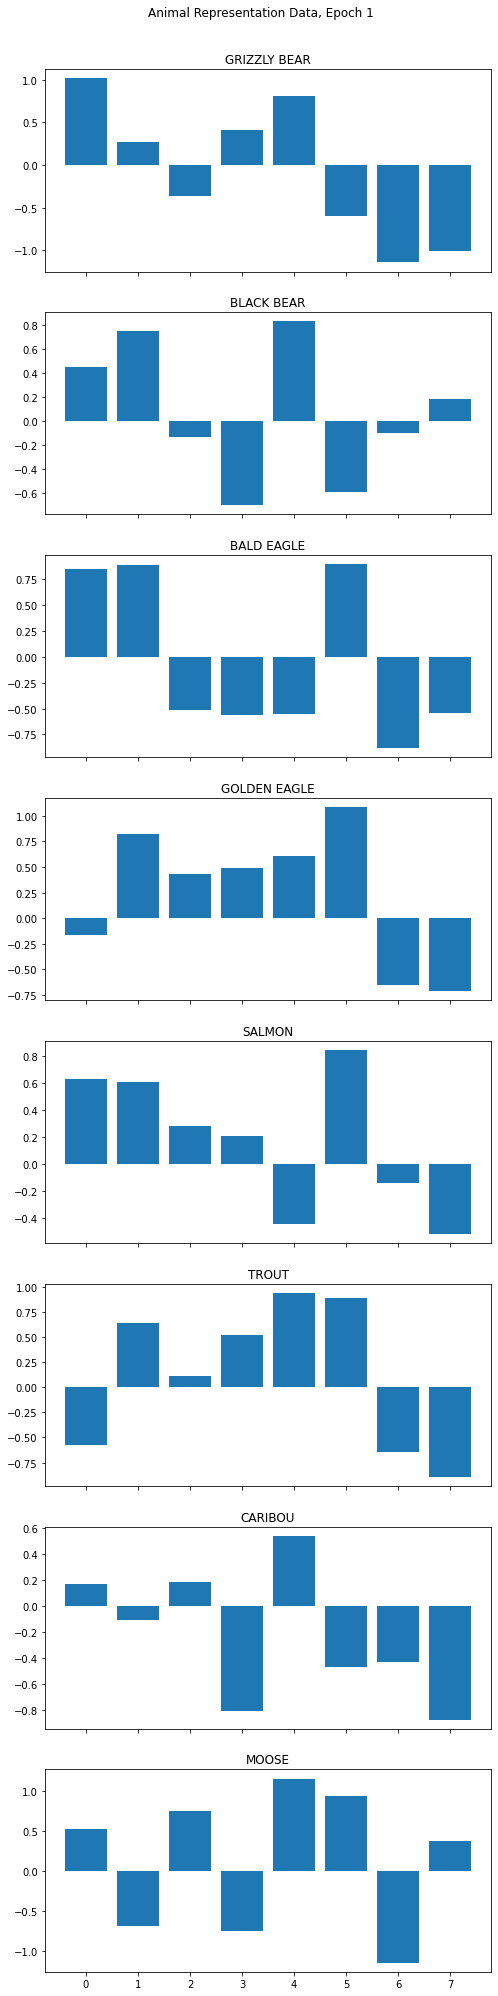

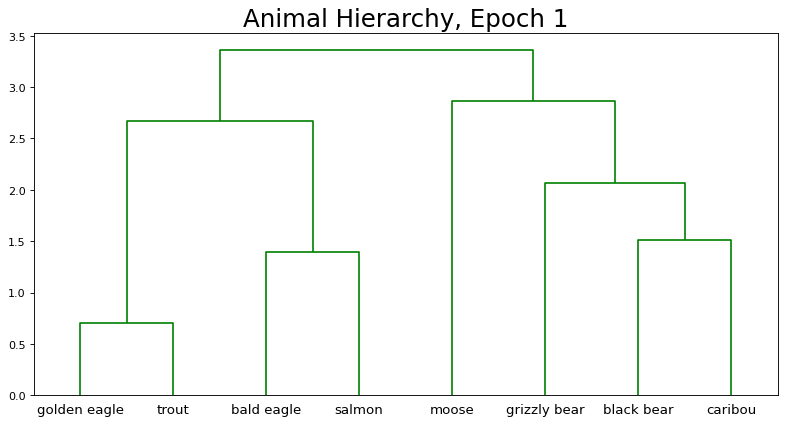

Test: IS	Average loss = 1.459165
Test: ISA	Average loss = 2.246414
Test: CAN	Average loss = 0.840968
Test: HAS	Average loss = 1.584309




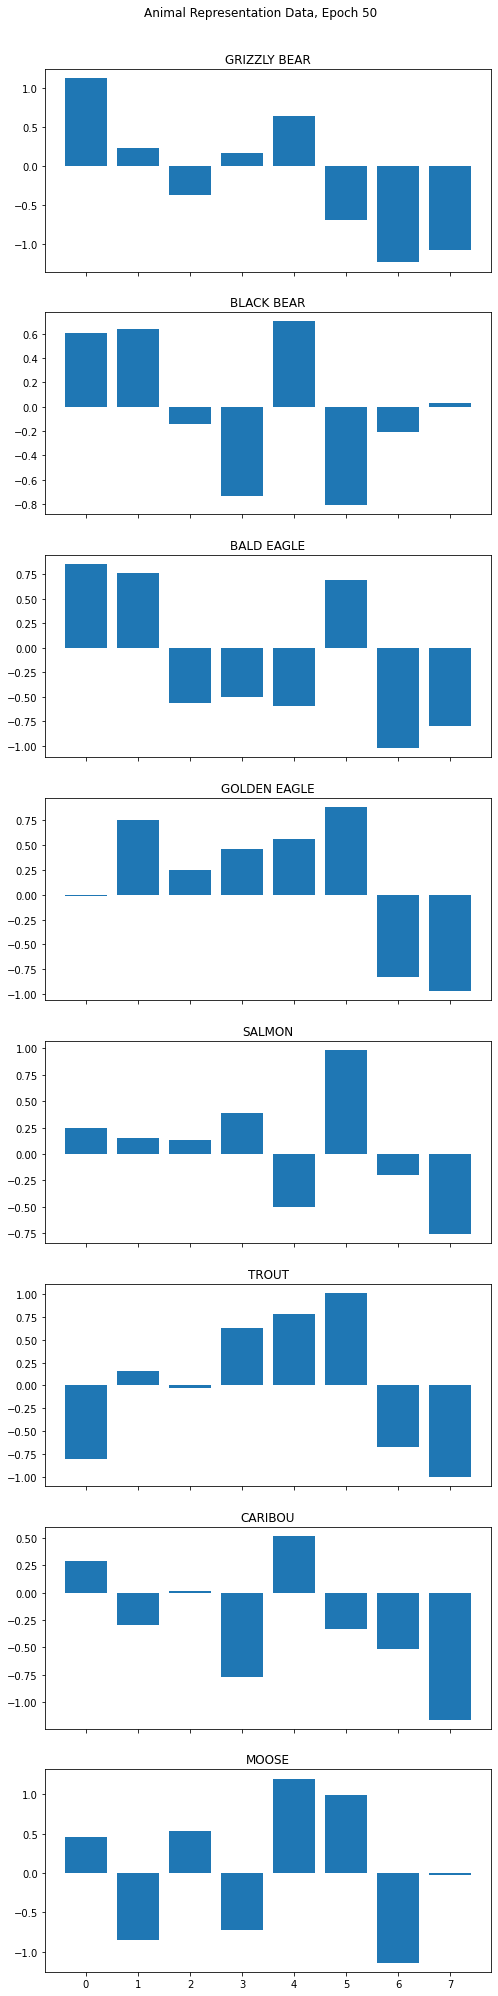

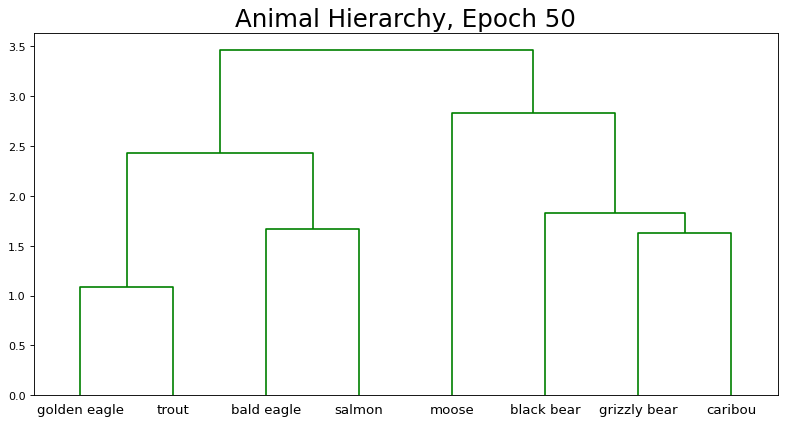

Test: IS	Average loss = 0.989461
Test: ISA	Average loss = 1.769322
Test: CAN	Average loss = 0.624009
Test: HAS	Average loss = 1.378601




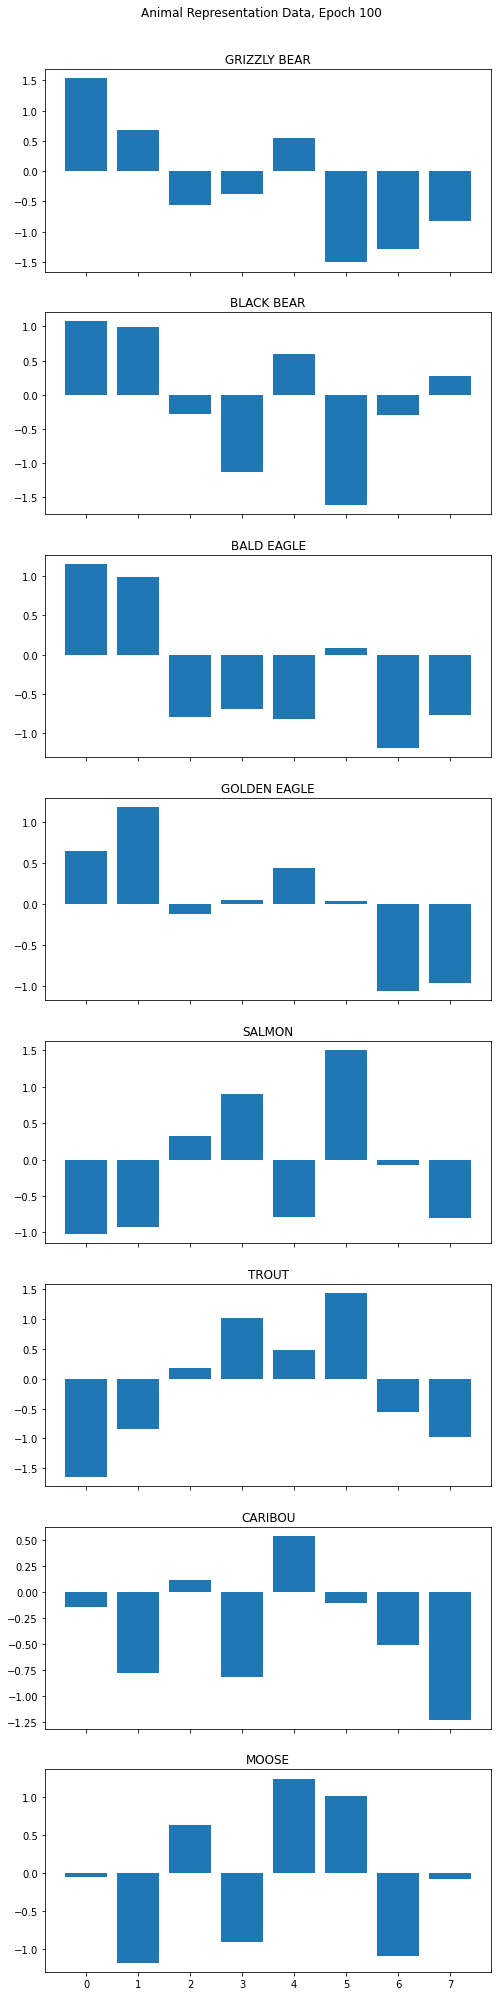

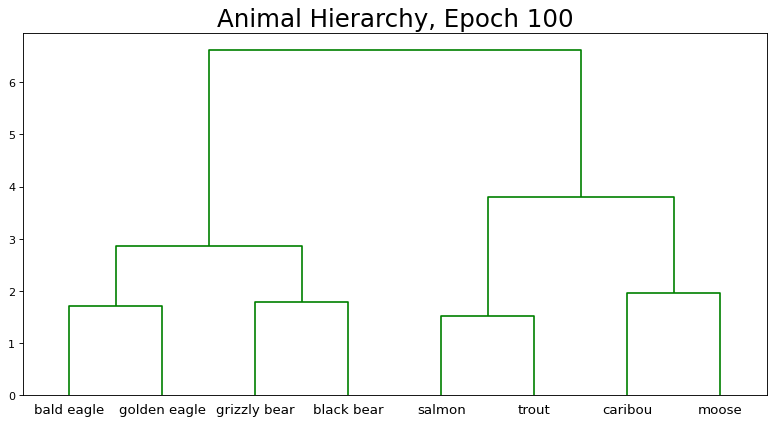

Train Epoch 175: 	Loss: 0.756938
Test: IS	Average loss = 0.440439
Test: ISA	Average loss = 1.108372
Test: CAN	Average loss = 0.390419
Test: HAS	Average loss = 0.976053


Train Epoch 350: 	Loss: 0.322170
Test: IS	Average loss = 0.182566
Test: ISA	Average loss = 0.526755
Test: CAN	Average loss = 0.056749
Test: HAS	Average loss = 0.456393


Train Epoch 525: 	Loss: 0.134282
Test: IS	Average loss = 0.131090
Test: ISA	Average loss = 0.193592
Test: CAN	Average loss = 0.032800
Test: HAS	Average loss = 0.153034


Train Epoch 700: 	Loss: 0.058752
Test: IS	Average loss = 0.055420
Test: ISA	Average loss = 0.081799
Test: CAN	Average loss = 0.021000
Test: HAS	Average loss = 0.071236


Train Epoch 875: 	Loss: 0.034814
Test: IS	Average loss = 0.029855
Test: ISA	Average loss = 0.049321
Test: CAN	Average loss = 0.014595
Test: HAS	Average loss = 0.043631




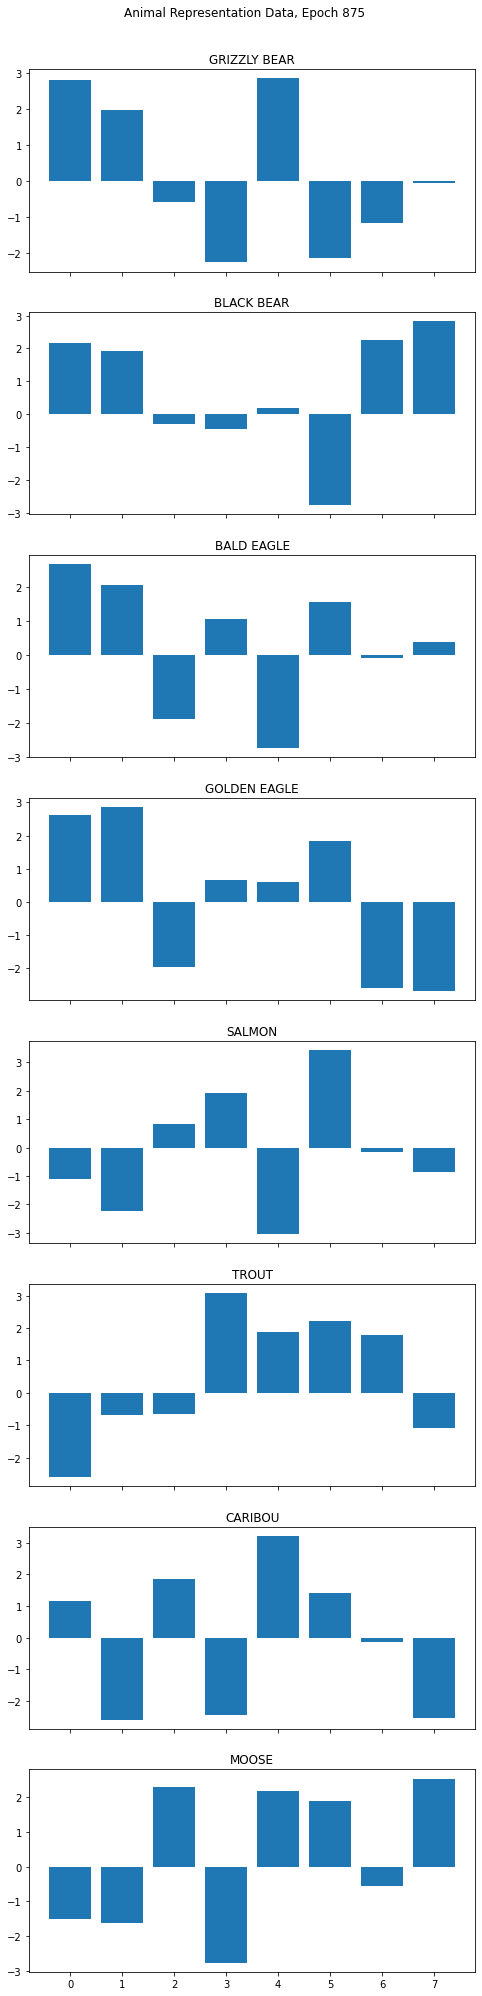

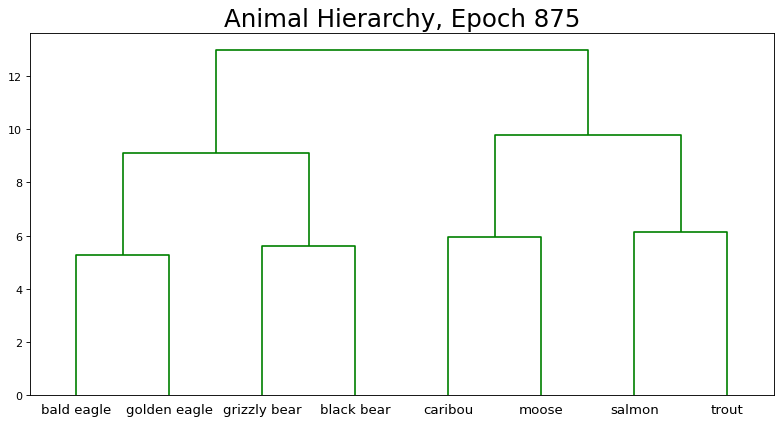

Train Epoch 1050: 	Loss: 0.024409
Test: IS	Average loss = 0.020088
Test: ISA	Average loss = 0.034904
Test: CAN	Average loss = 0.010972
Test: HAS	Average loss = 0.030773


Train Epoch 1225: 	Loss: 0.018672
Test: IS	Average loss = 0.015045
Test: ISA	Average loss = 0.026856
Test: CAN	Average loss = 0.008714
Test: HAS	Average loss = 0.023554


Train Epoch 1400: 	Loss: 0.015061
Test: IS	Average loss = 0.011983
Test: ISA	Average loss = 0.021743
Test: CAN	Average loss = 0.007197
Test: HAS	Average loss = 0.018983


Train Epoch 1575: 	Loss: 0.012588
Test: IS	Average loss = 0.009931
Test: ISA	Average loss = 0.018223
Test: CAN	Average loss = 0.006115
Test: HAS	Average loss = 0.015849


Train Epoch 1750: 	Loss: 0.010794
Test: IS	Average loss = 0.008467
Test: ISA	Average loss = 0.015657
Test: CAN	Average loss = 0.005305
Test: HAS	Average loss = 0.013576




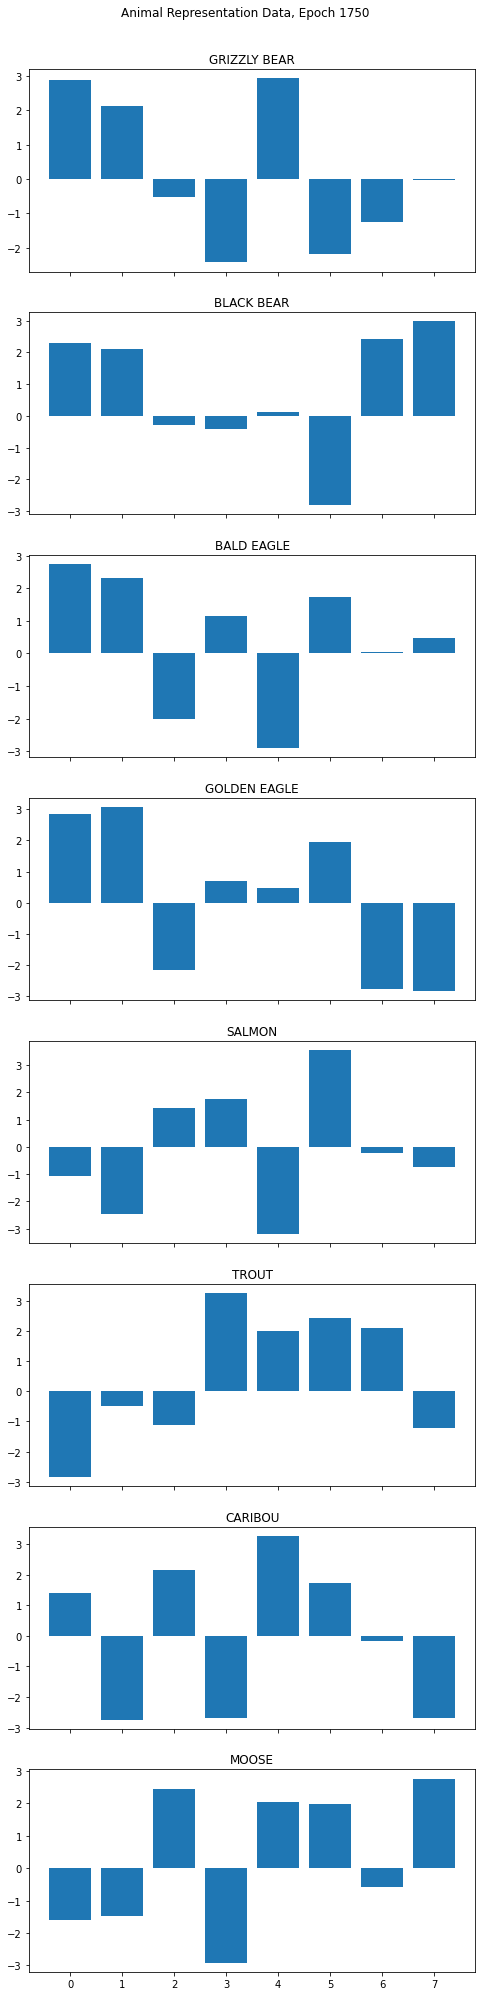

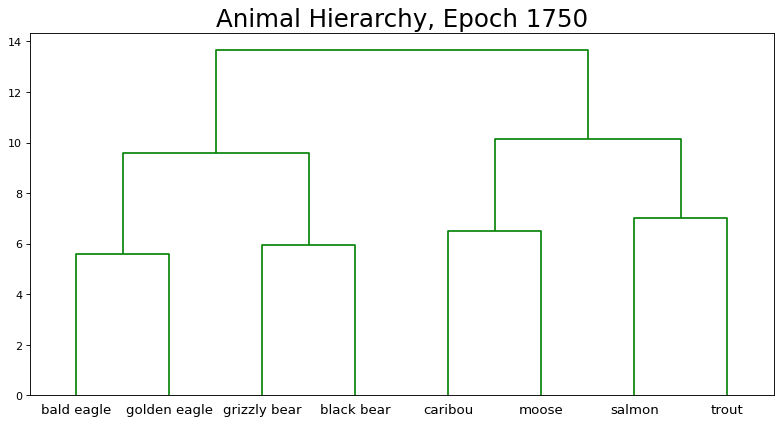

Train Epoch 1925: 	Loss: 0.009437
Test: IS	Average loss = 0.007371
Test: ISA	Average loss = 0.013708
Test: CAN	Average loss = 0.004678
Test: HAS	Average loss = 0.011859


Train Epoch 2100: 	Loss: 0.008375
Test: IS	Average loss = 0.006522
Test: ISA	Average loss = 0.012180
Test: CAN	Average loss = 0.004178
Test: HAS	Average loss = 0.010516


Train Epoch 2275: 	Loss: 0.007522
Test: IS	Average loss = 0.005846
Test: ISA	Average loss = 0.010950
Test: CAN	Average loss = 0.003771
Test: HAS	Average loss = 0.009440


Train Epoch 2450: 	Loss: 0.006823
Test: IS	Average loss = 0.005294
Test: ISA	Average loss = 0.009940
Test: CAN	Average loss = 0.003433
Test: HAS	Average loss = 0.008559


Train Epoch 2625: 	Loss: 0.006241
Test: IS	Average loss = 0.004836
Test: ISA	Average loss = 0.009096
Test: CAN	Average loss = 0.003149
Test: HAS	Average loss = 0.007825




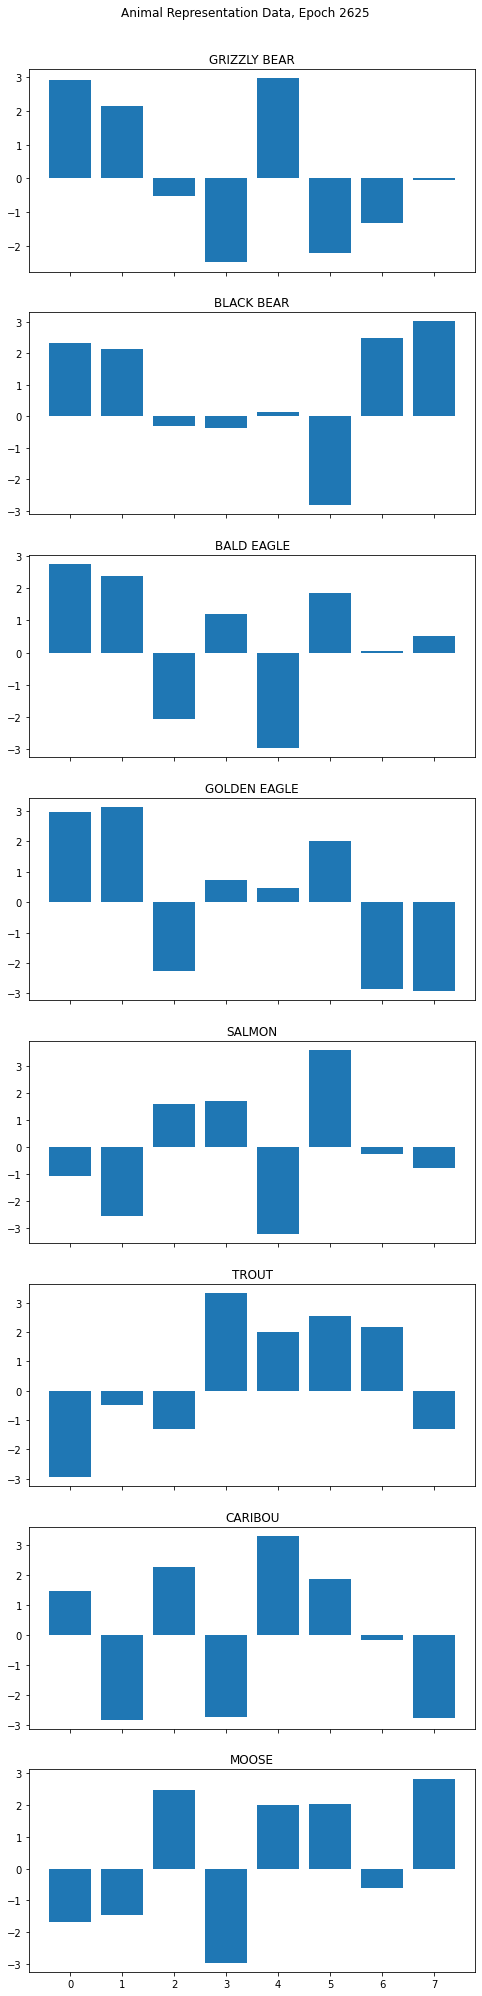

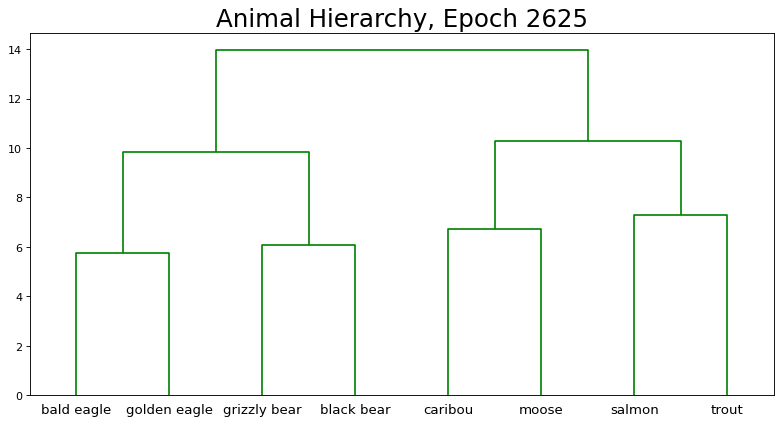

Train Epoch 2800: 	Loss: 0.005747
Test: IS	Average loss = 0.004449
Test: ISA	Average loss = 0.008381
Test: CAN	Average loss = 0.002906
Test: HAS	Average loss = 0.007204


Train Epoch 2975: 	Loss: 0.005324
Test: IS	Average loss = 0.004119
Test: ISA	Average loss = 0.007768
Test: CAN	Average loss = 0.002696
Test: HAS	Average loss = 0.006673


Train Epoch 3150: 	Loss: 0.004958
Test: IS	Average loss = 0.003833
Test: ISA	Average loss = 0.007236
Test: CAN	Average loss = 0.002513
Test: HAS	Average loss = 0.006213


Train Epoch 3325: 	Loss: 0.004638
Test: IS	Average loss = 0.003584
Test: ISA	Average loss = 0.006771
Test: CAN	Average loss = 0.002353
Test: HAS	Average loss = 0.005811


Train Epoch 3500: 	Loss: 0.004355
Test: IS	Average loss = 0.003365
Test: ISA	Average loss = 0.006361
Test: CAN	Average loss = 0.002211
Test: HAS	Average loss = 0.005457




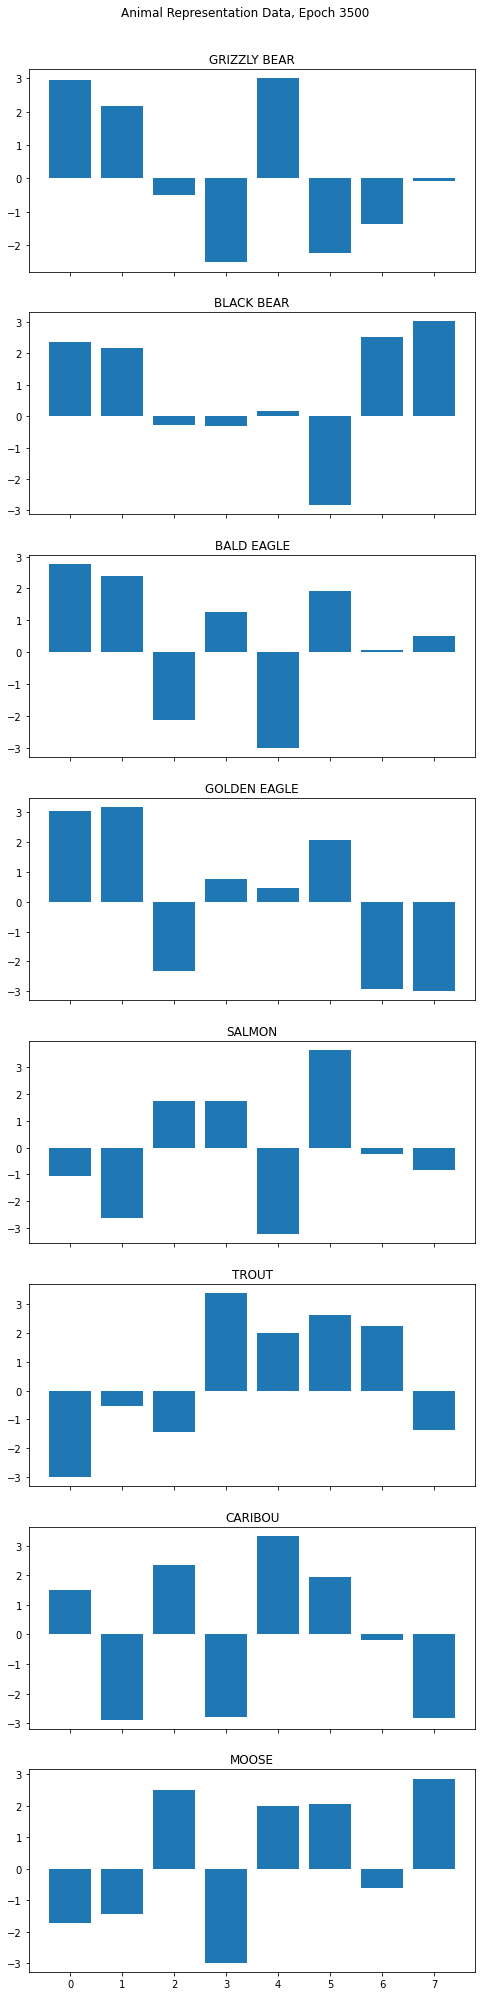

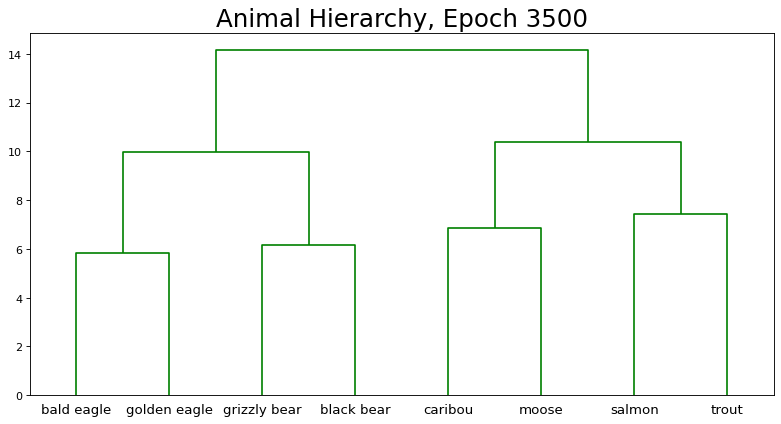

In [16]:
# Commence training and testing
# Also print out representation graphs every 875 epochs
for epoch in range(1, num_epochs + 1):
  train(epoch)
  if (epoch == 1) or (epoch == 50) or (epoch == 100) or (epoch % (num_epochs // 20) == 0):
    test(epoch)
    print("\n")
  if (epoch == 1) or (epoch == 50) or (epoch == 100) or (epoch % (num_epochs // 4) == 0):
    rep_data_list = create_rep_graphs(epoch)
    create_dendrogram(rep_data_list, epoch)

# Stage 4: Visualizations

In [17]:
# Create function for making graphs comparing target vs. actual output
# z: specifying which relation's output should be graphed
def create_output_graphs(z):
  with torch.no_grad():
    print("Results for {}:".format(relations_list[z]))
    for index, (data, target) in enumerate(relation_DL_order[z]):
      x, y = data
      output = network(data)
      fig, axs = plt.subplots(figsize=(22,3))
      plt.tight_layout()
      labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
      axs.plot(labels, output.numpy()[0], 'o', label='output')
      axs.plot(labels, target.numpy()[0], 'o', label='target')
      axs.set_xlabel('\nattributes')
      axs.set_ylabel('value')
      axs.set_title(f"{animals_list[index]}, {relations_list[z]}")
      plt.legend();

Results for IS:


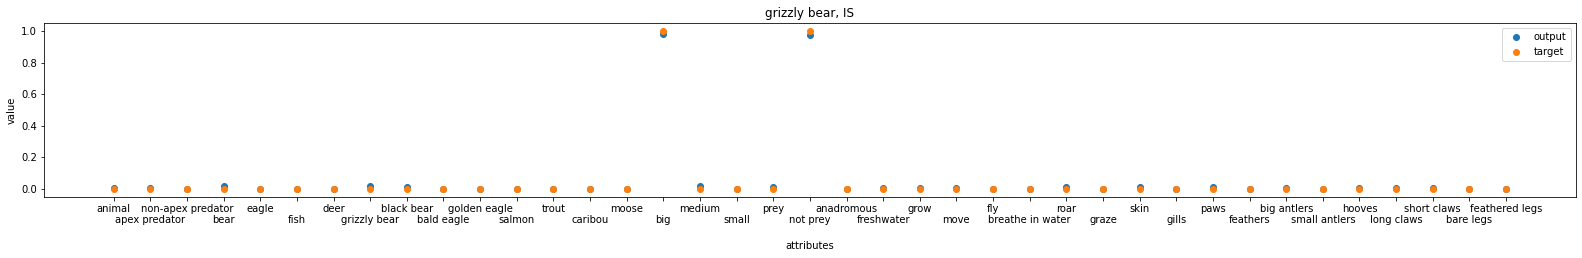

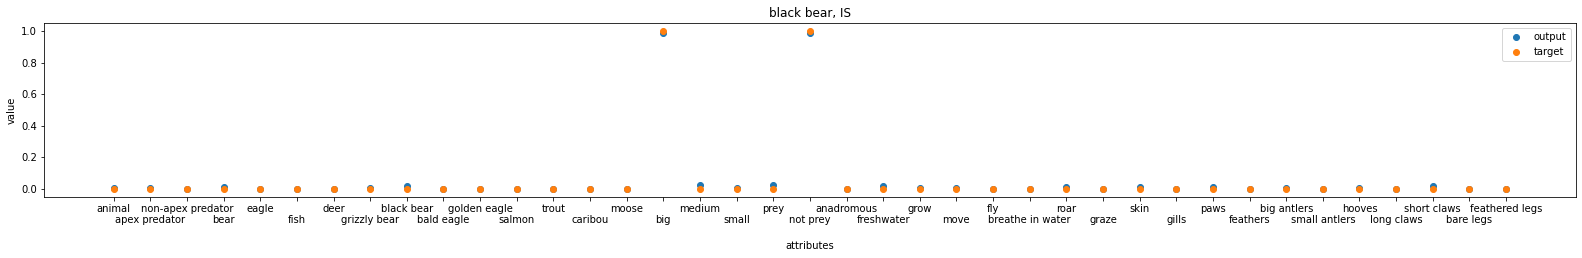

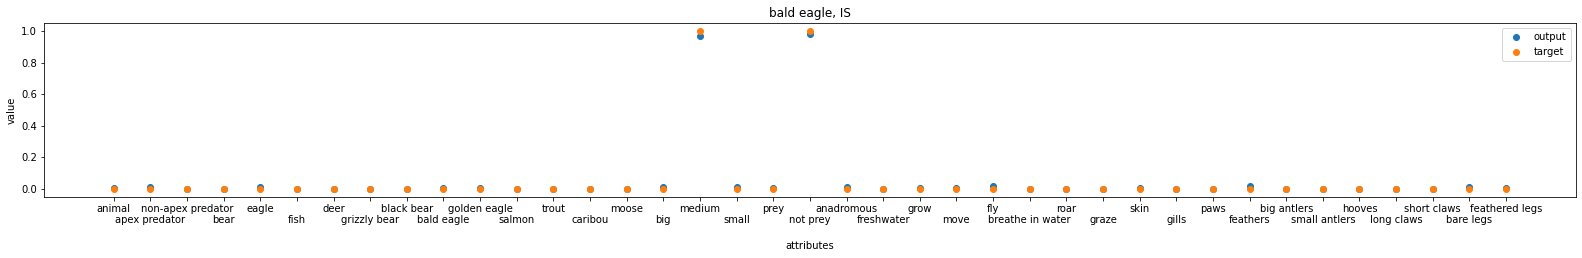

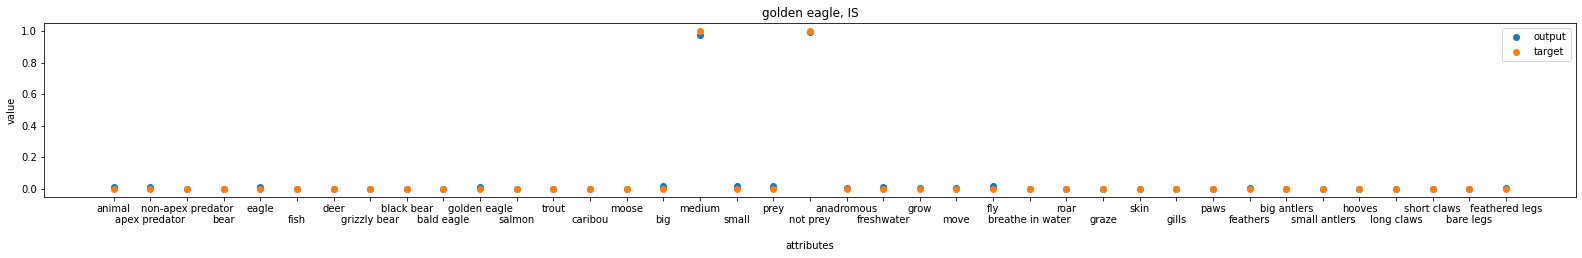

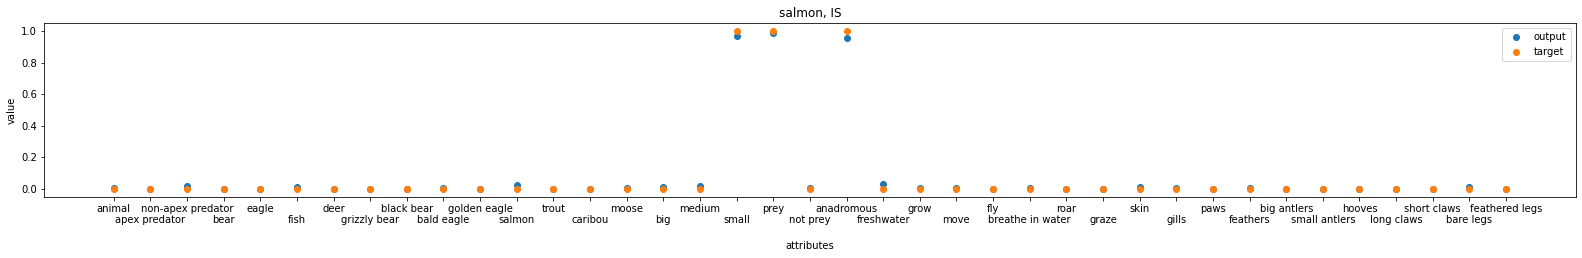

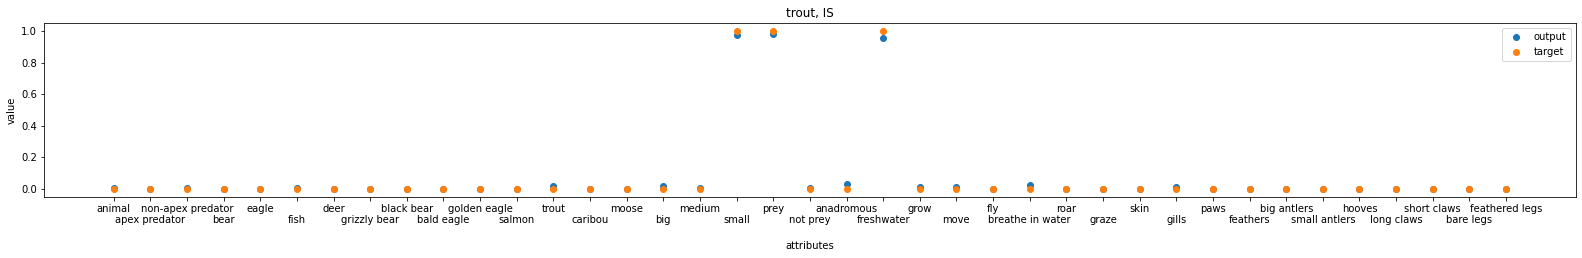

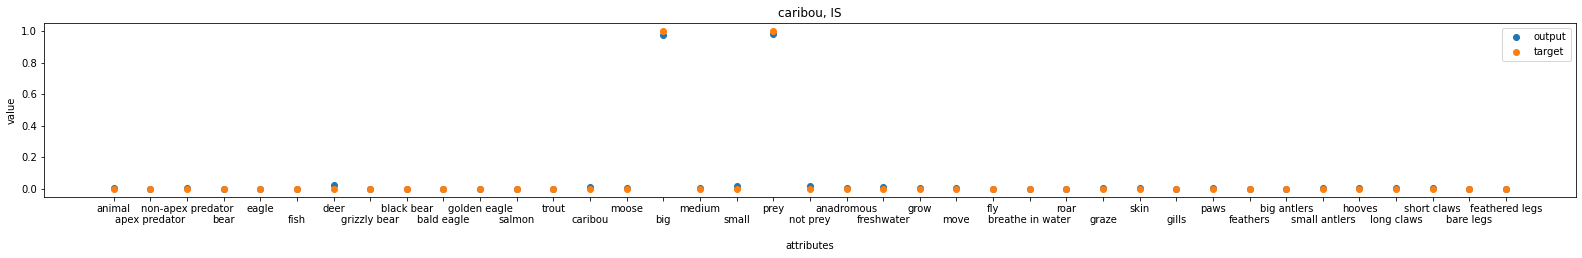

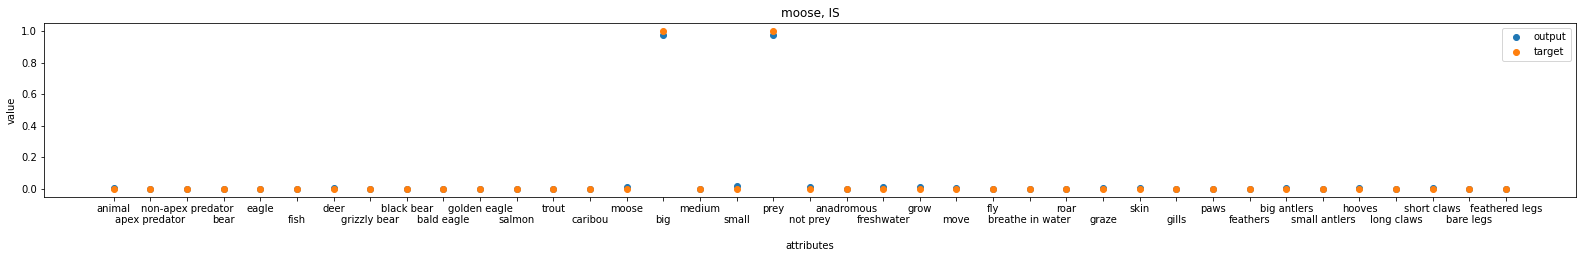

In [18]:
# Display final results (IS) post-training
create_output_graphs(0)

Results for ISA:


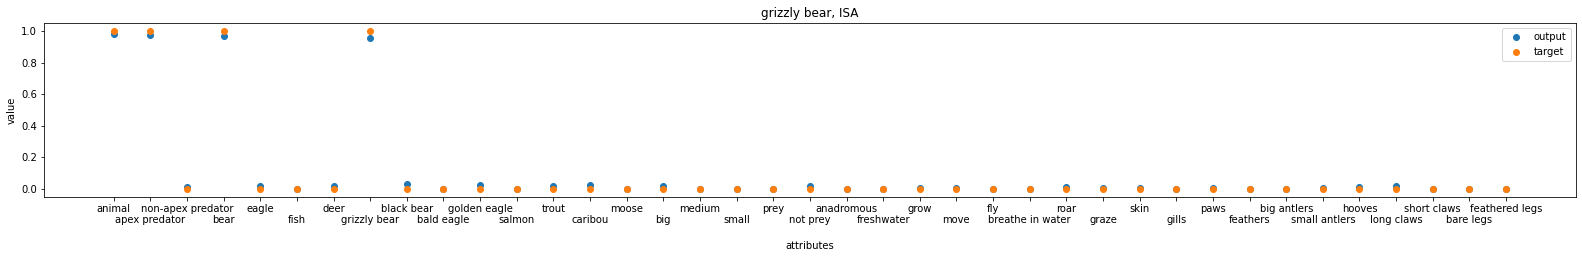

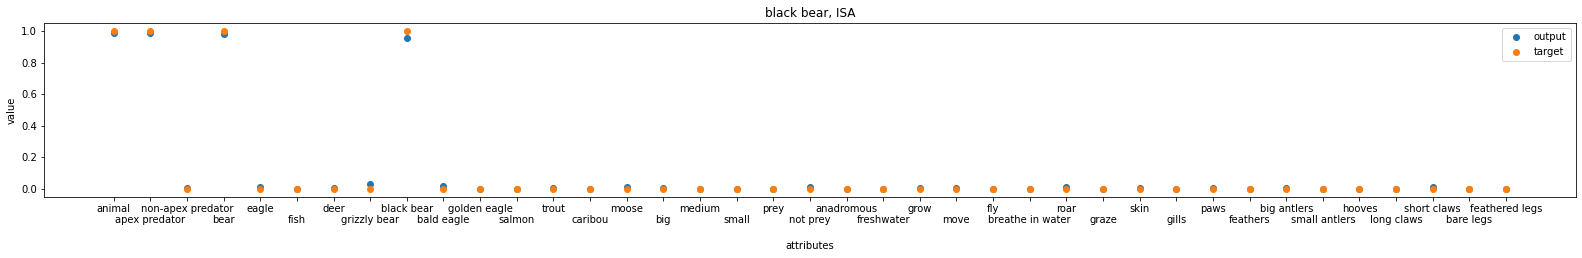

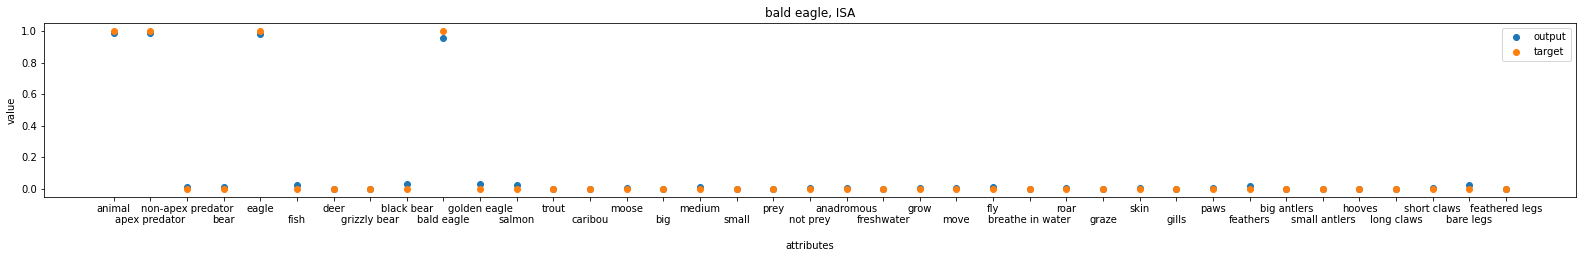

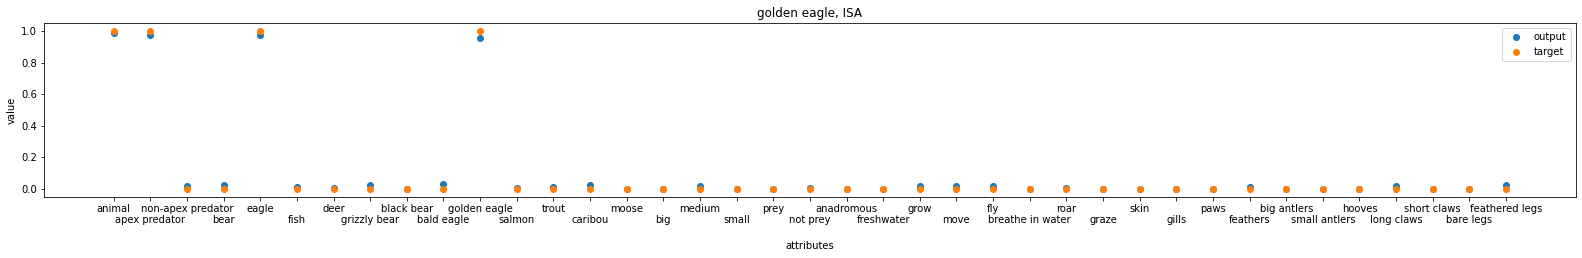

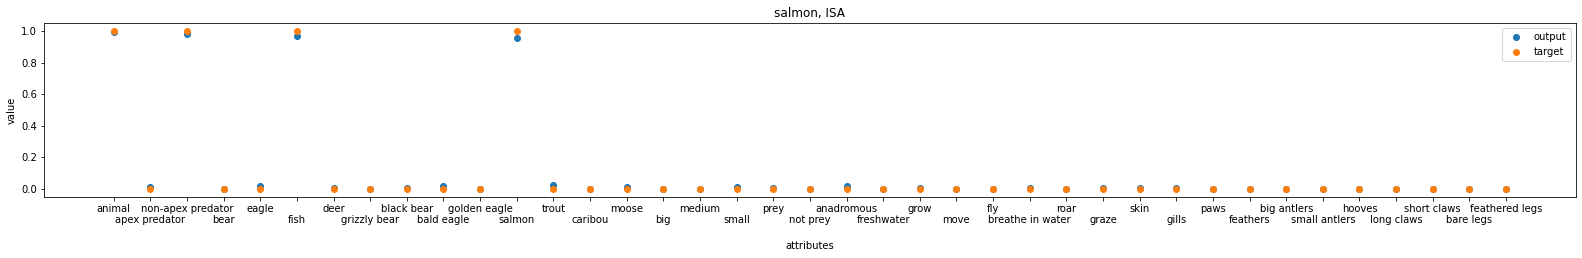

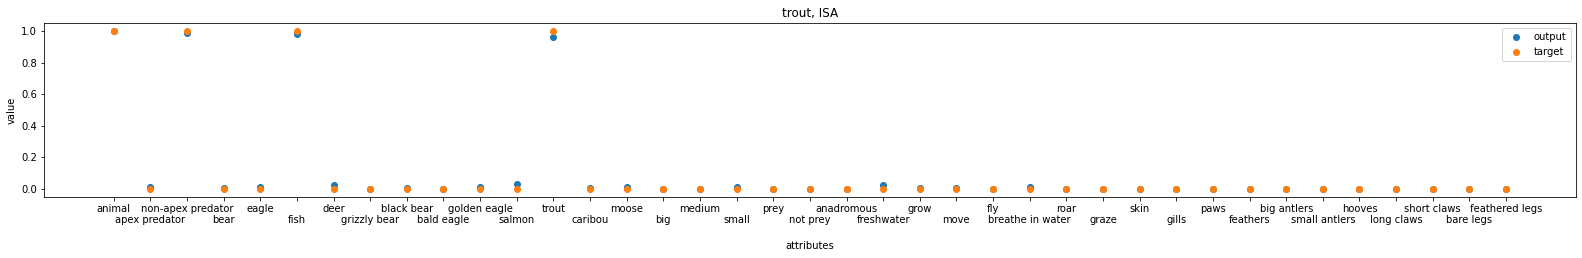

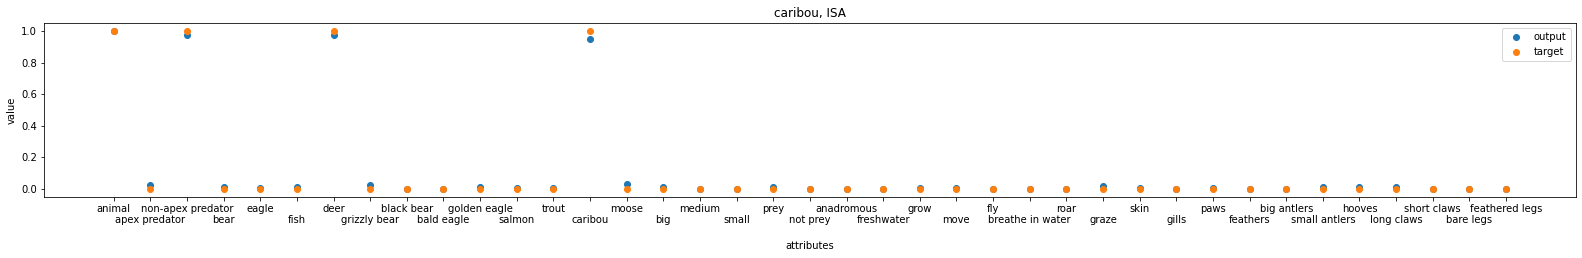

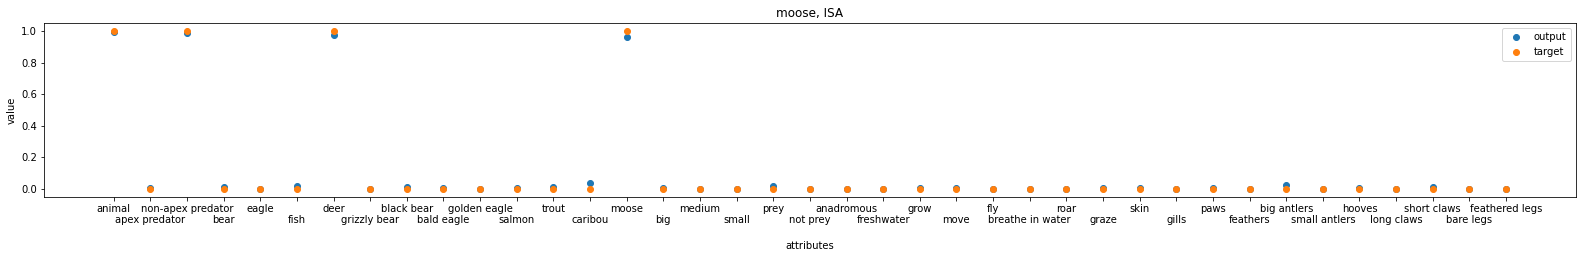

In [19]:
# Display final results (ISA) post-training
create_output_graphs(1)

Results for CAN:


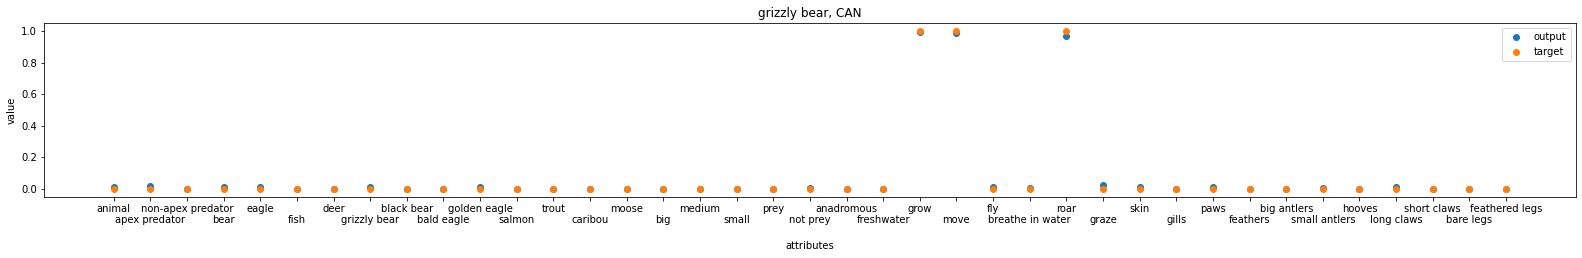

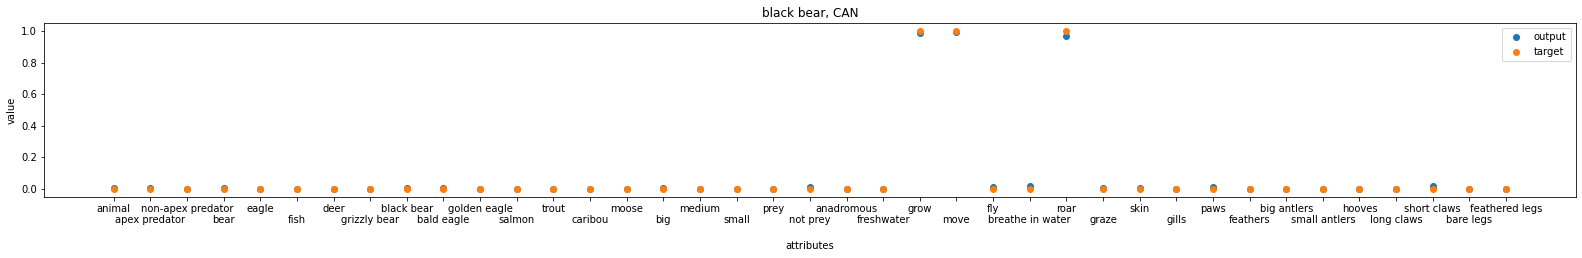

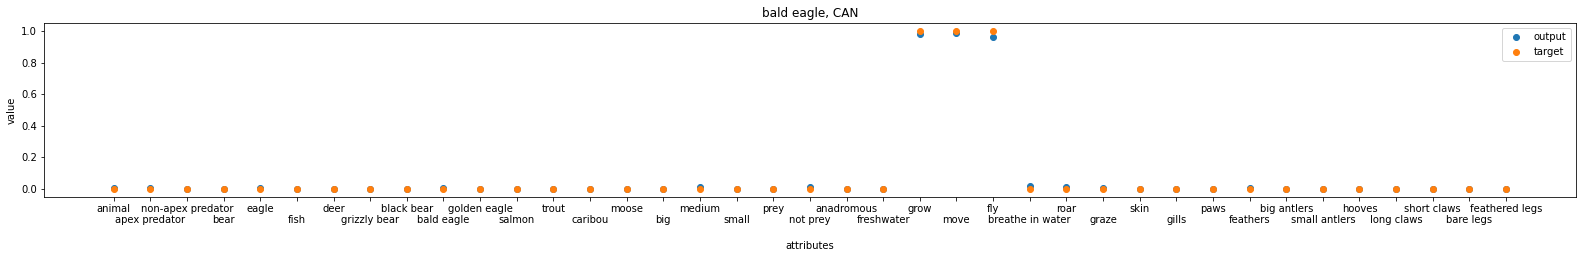

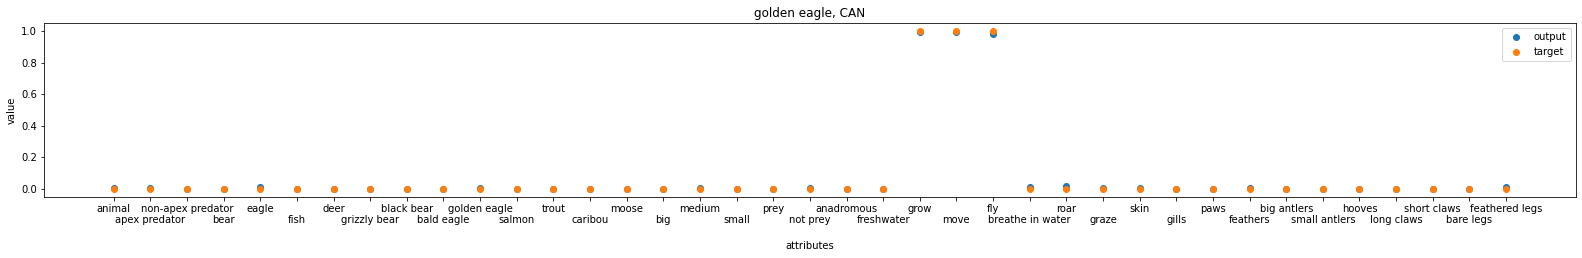

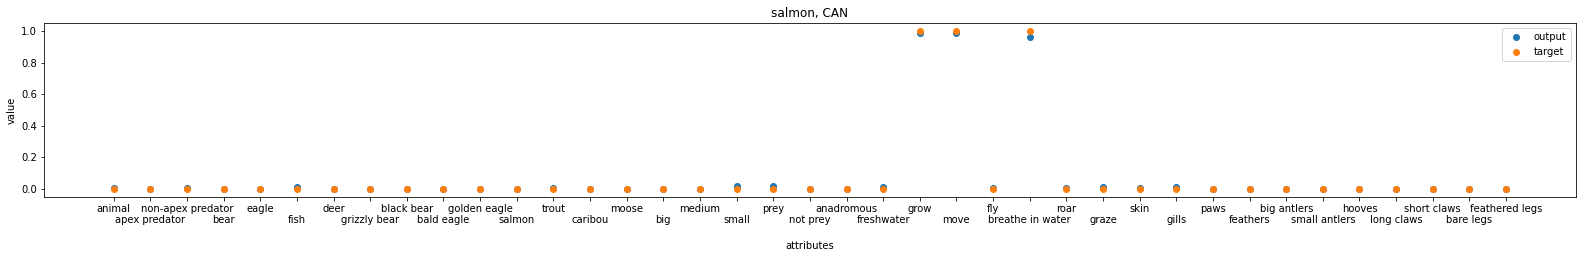

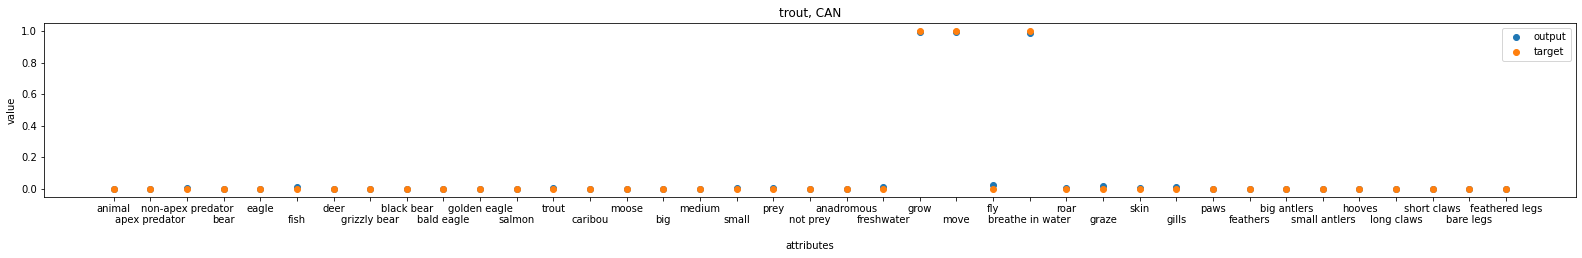

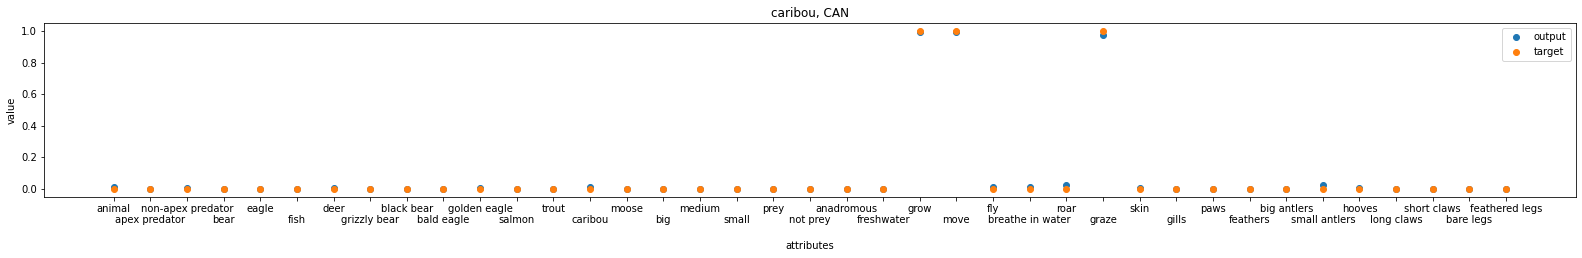

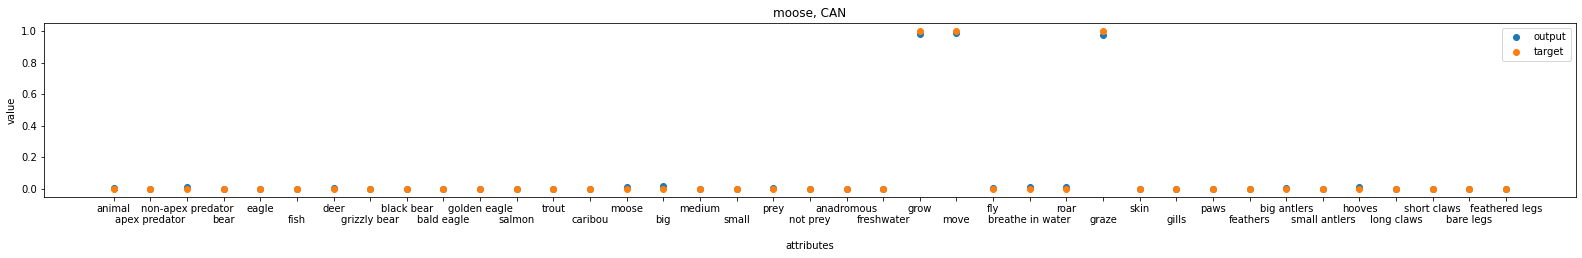

In [20]:
# Display final results (CAN) post-training
create_output_graphs(2)

Results for HAS:


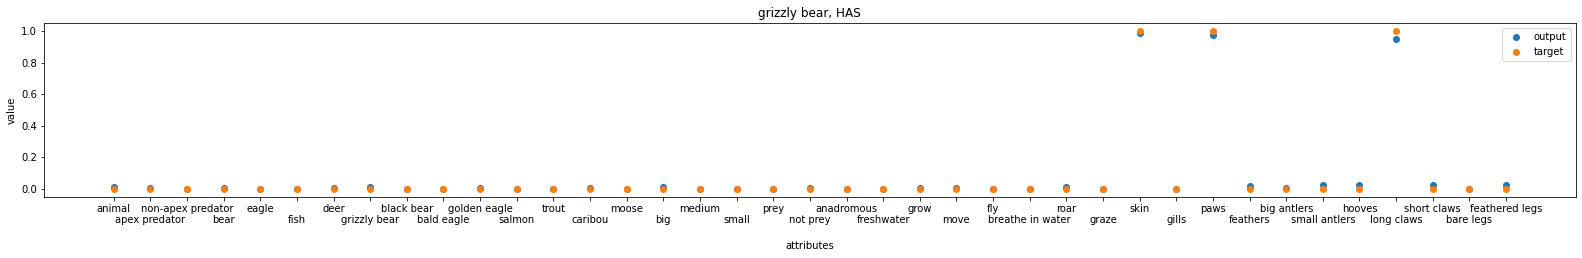

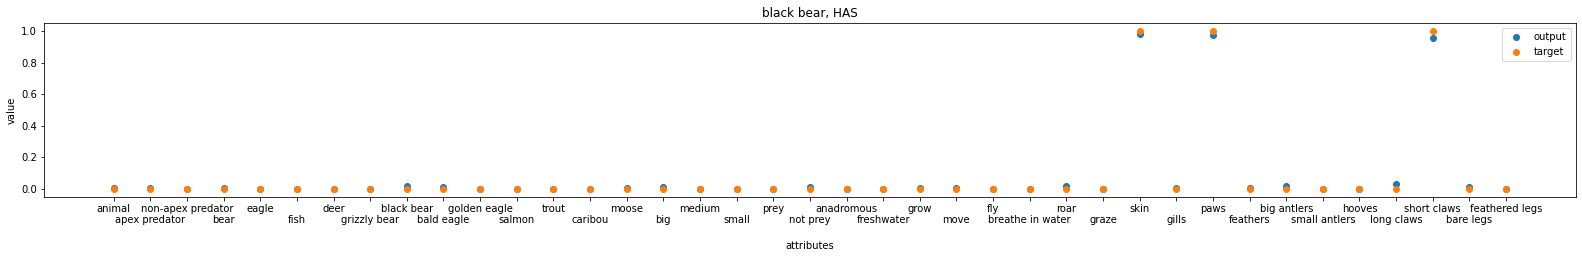

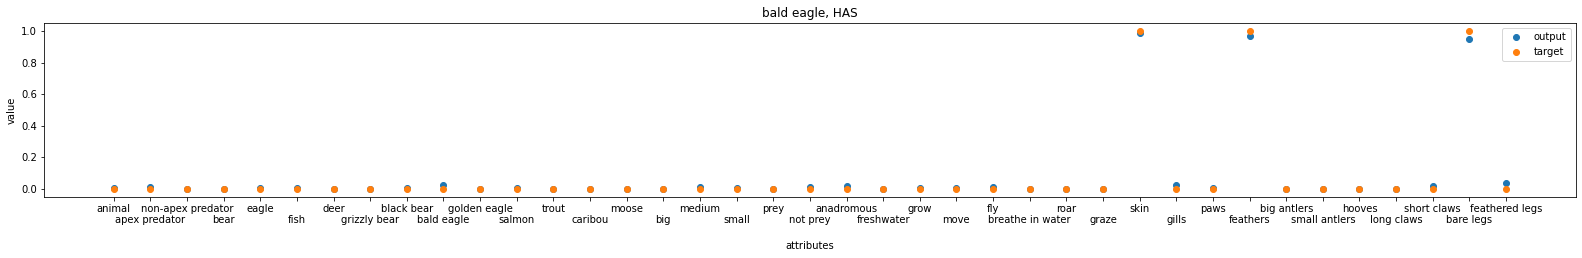

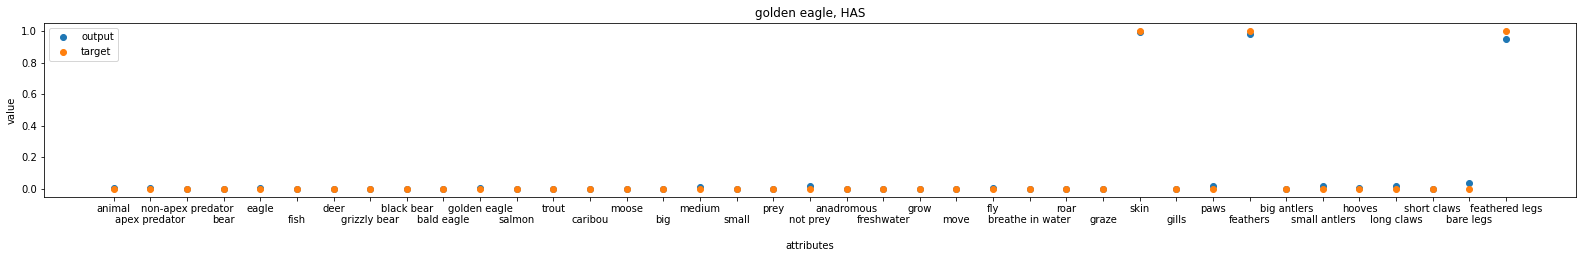

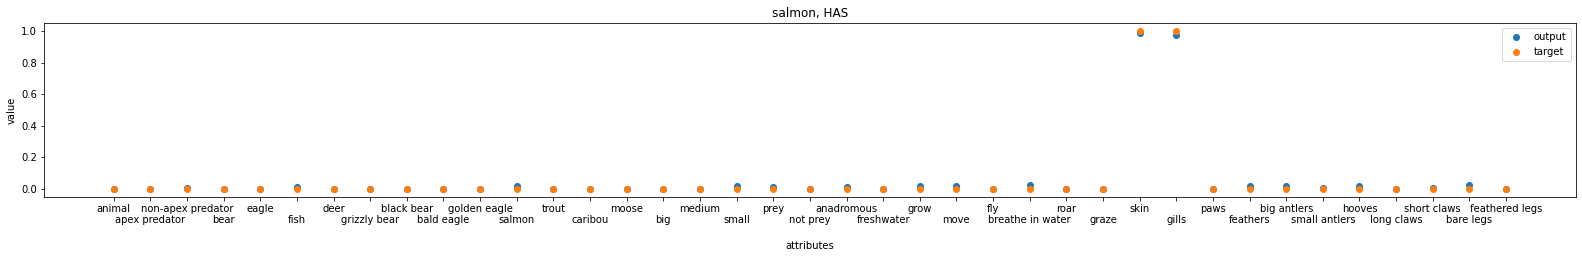

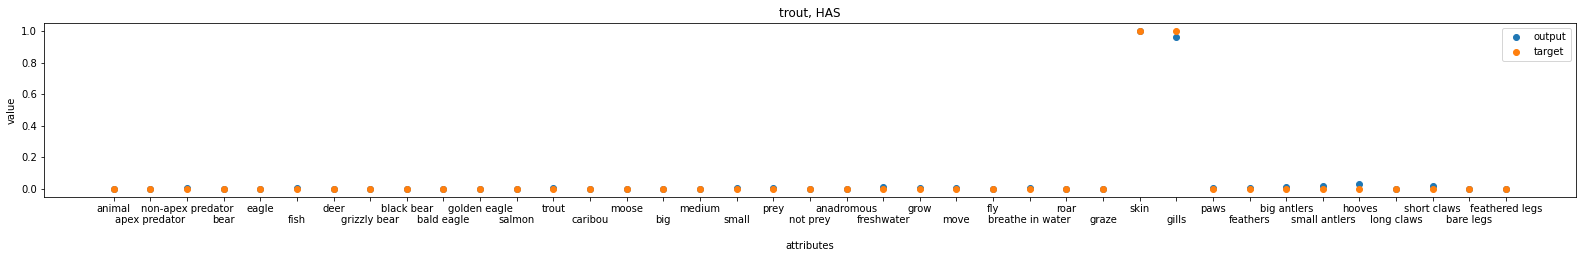

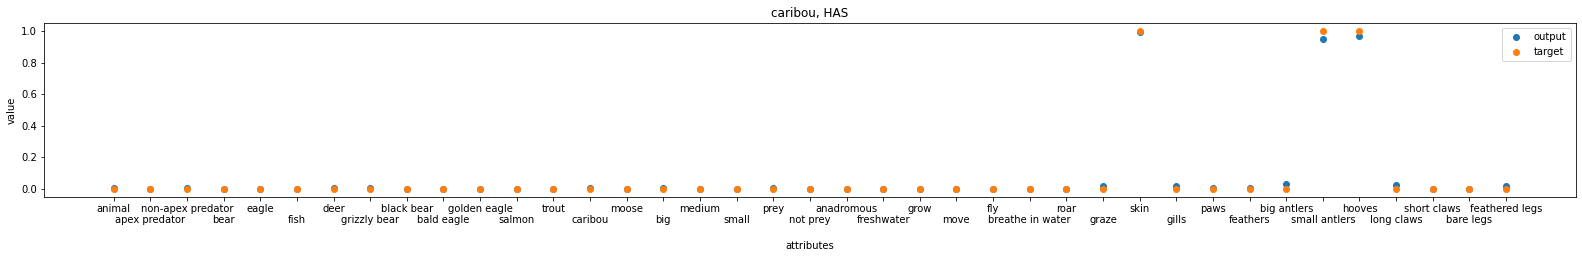

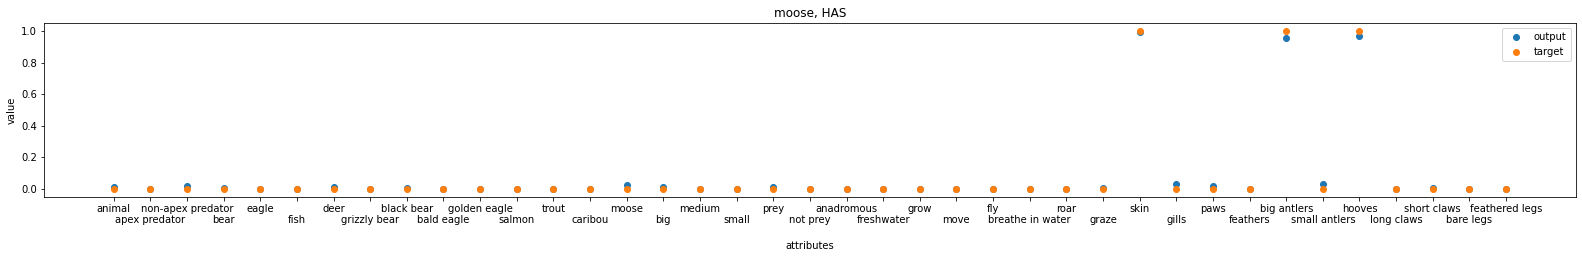

In [21]:
# Display final results (HAS) post-training
create_output_graphs(3)